# AI_campus_ProstateSeg 
# Module 9: Unsupervised Image Segmentation Using Mean-Shift
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

In continuation of the previous module (module 8), this notebook walks through another example of unsupervised image segmentation using mean-shift clustering. In unsupervised machine learning, a model learns patterns from the data itself without relying on any external supervisory signal in the form of class labels, which in this case are the segmentation masks corresponding to each image. The mean-shift clustering algorithm is a density-based clustering algorithm that iteratively shifts a window towards the densest areas of the data distribution. Unlike K-means, which assumes a fixed number of clusters and clusters data based on the centroid of each cluster, mean-shift does not depend on a pre-defined number of clusters. The algorithm requires a bandwidth parameter to be set, which determines how a point moves towards the nearest mode (or the region of highest density). The bandwidth parameter determines the size or radius of a circular window around each data point that is used during the mean shift iterations. When the bandwidth is small, the algorithm focuses on smaller, more local regions of high density points. Resultantly, cluster boundaries are likely to be more fine-grained, and the algorithm may detect more clusters in areas of the data with small variations in the density. On the contrary, when a large bandwidth is chosen, lesser number of clusters are detected, which are likely to be larger. 

## 1. Import the necessary packages

In [9]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch
import torchvision.transforms as transforms
import cv2

from PIL import Image
from typing import List, Set, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset
from dataclass import ToyPANDASDataset
from torchvision.transforms import functional as F
from scipy.stats import entropy
from normalizers import ChannelWiseMinMaxNormalizer
from sklearn.cluster import MeanShift

## 2. Define folder and subdirectory folder names

In [2]:
ROOT_FOLDER = "sample_data"
IMAGE_SUBFOLDER = "train_images"
MASK_SUBFOLDER = "train_label_masks"

image_dir = os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER)
mask_dir = os.path.join(ROOT_FOLDER, MASK_SUBFOLDER)

## 3. Create list of image and mask files and print contents

In [32]:
image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(image_dir))))
mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(mask_dir))))

In [33]:
image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

In [34]:
mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

### 6. Write function to draw mask on an image given a boolean mask and class labels

In [4]:
def draw_mask(image: np.ndarray, 
              mask: np.ndarray,
              color_rgb_list: List[int] = [0, 255, 0]):
    
    """
    Function to draw mask on an image based on the
    mask given (mask). The mask will be translucent
    green given the default color in color_rgb_list = [0, 225, 0]
    
    Parameters
    -----------
    image: np.ndarray
        The image over which the mask is to be overlayed
    
    mask: np.ndarray
        The mask that is to be overlayed on the image. 
        This mask must be boolean (containing only True or False)
        
    color_rgb_list: List[int]
        The RGB pixel configuration of the color of the translucent
        mask to overlay on the image. 
        Default = [0, 255, 0] (green)
    
    Returns
    ---------
    np.ndarray
        The image with the colored mask overlaid along the 
        pixel locations which indicate True in the mask. 
    
    """
    
    masked_image = image.copy()
    masked_image = np.where(mask.astype(int),
                            np.array(color_rgb_list, dtype='uint8'),
                            masked_image)

    masked_image = masked_image.astype(np.uint8)

    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

### 7. Write function to plot segmented image by label

In [5]:
def plot_segmented_image_by_label(image: np.ndarray,
                                  mask: np.ndarray,
                                  label_id: int):
    
    """
    Function to plot segmented image by label.
    Given an image and mask pair, the function
    plots the image by applying the segmentation
    mask for a specific label. The mask contains
    integers values to represent the different class
    labels. The function only applies segmentation
    mask for pixel locations where that label_id is
    present.
    
    Parameters
    -----------
    image: np.ndarray
        The input image.
    
    mask: np.ndarray
        The mask with integer labels.
    
    label_id: int
        The class label, represented as an integer
    
    Returns
    ---------
    Plots the image with segmentation mask applied
    to the pixel locations where the given label_id
    is present. 
    
    """
    
    avail_labels = list(putil.enlist_class_presence(mask))
    assert label_id in avail_labels
    
    assert image.shape == mask.shape
    assert image.shape[-1] == 3 and mask.shape[-1] == 3
    
    assert np.sum(mask[:,:,1]) == 0 and np.sum(mask[:,:,2]) == 0
    
    if np.sum(mask[:,:,0]) == 0:
        print("The image is all background")
    
    reduced_mask = mask[:, :, 0]
    assert len(reduced_mask.shape) == 2
    
    assert set(list(np.unique(reduced_mask))) == set(avail_labels)
    
    boolean_label_mask = reduced_mask == label_id
    assert (reduced_mask == label_id).sum() == boolean_label_mask.sum()
    
    n_on_bits_for_label = (reduced_mask == label_id).sum()
    
    boolean_label_mask_3d = np.repeat(boolean_label_mask[:, :, np.newaxis], 3, axis=2)
    
    for i in range(3):
        assert np.sum(boolean_label_mask_3d[:, :, i]) == n_on_bits_for_label
        
    segmented_image = draw_mask(image, boolean_label_mask_3d)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    ax[0].imshow(image)
    ax[0].set_title('Original Image')  
    ax[0].axis('on')  

    ax[1].imshow(segmented_image)
    ax[1].set_title(f'Segmented Image by label_id: {label_id}')  
    ax[1].axis('on')  

    plt.tight_layout()

    plt.show()

### 9. Write function to apply segment to image by a label

In [6]:
def apply_segment_to_image_by_label(image,
                                    mask,
                                    label_id,
                                    color_lst):
    
    """
    Function to apply segmentation mask to image
    for a specific label_id
    
    Parameters
    -----------
    image: np.ndarray
        The image to which the segmentation mask is to
        be applied for that specific label_id
    
    mask: np.ndarray
        The mask which is to be applied to the image
        where the label_id is present
    
    label_id: int
        The label_id that is to be applied to the
        image from the segmentation mask
    
    color_lst: List[int]
        The color, expressed as list of RGB integer values,
        to be applied to the image where the label_id is
        present in the corresponding segmentation mask
    
    Returns
    --------
    np.ndarray
        The image with the segmentation mask applied
        at the pixel locations where label_id is present
        
    """
    
    avail_labels = list(putil.enlist_class_presence(mask))
    #assert label_id in avail_labels
    
    assert image.shape == mask.shape
    assert image.shape[-1] == 3 and mask.shape[-1] == 3
    
    assert np.sum(mask[:,:,1]) == 0 and np.sum(mask[:,:,2]) == 0
    
    if np.sum(mask[:,:,0]) == 0:
        print("The image is all background")
    
    reduced_mask = mask[:, :, 0]
    assert len(reduced_mask.shape) == 2
    
    assert set(list(np.unique(reduced_mask))) == set(avail_labels)
    
    boolean_label_mask = reduced_mask == label_id
    assert (reduced_mask == label_id).sum() == boolean_label_mask.sum()
    
    n_on_bits_for_label = (reduced_mask == label_id).sum()
    
    boolean_label_mask_3d = np.repeat(boolean_label_mask[:, :, np.newaxis], 3, axis=2)
    
    for i in range(3):
        assert np.sum(boolean_label_mask_3d[:, :, i]) == n_on_bits_for_label
        
    segmented_image = draw_mask(image, boolean_label_mask_3d, color_rgb_list = color_lst)
    
    return segmented_image

### 10. Write function to apply segment to image by multiple labels

In [11]:
def apply_segment_to_image_by_multiple_labels(image: np.ndarray,
                                              mask: np.ndarray,
                                              label_ids: List[int],
                                              color_rgb_pixels: List[list[int,int,int]] = [[0, 255, 0],
                                                                                           [255, 0, 0],
                                                                                           [0, 0, 255],
                                                                                           [255, 255, 0],
                                                                                           [255, 0, 255],
                                                                                           [0, 255, 255],
                                                                                           [255, 165, 0],
                                                                                           [128, 0, 128],
                                                                                           [139, 69, 19],
                                                                                           [255, 192, 203],
                                                                                           [169, 169, 169],
                                                                                           [245, 245, 220]],
                                              colors: List[str] = ["green",
                                                                    "red",
                                                                    "blue",
                                                                    "yellow",
                                                                    "magenta",
                                                                     "cyan",
                                                                    "orange",
                                                                     "purple",
                                                                      "brown",
                                                                       "pink",
                                                                        "gray",
                                                                        "beige"],
                                              
                                              id_to_class: Dict[int, str] = {0:"background (non tissue) or unknown",
                                                                             1:"stroma (connective tissue, non-epithelium tissue)",
                                                                             2: "healthy (benign) epithelium",
                                                                             3: "cancerous epithelium (Gleason 3)",
                                                                             4: "cancerous epithelium (Gleason 4)",
                                                                             5: "cancerous epithelium (Gleason 5)"},
                                               print_color: bool = False) -> np.ndarray:
    
    for i in range(len(label_ids)):
        image = apply_segment_to_image_by_label(image = image,
                                                mask = mask,
                                                label_id = label_ids[i],
                                                color_lst = color_rgb_pixels[i])
        if print_color:
            print(f"{colors[i]} : {id_to_class[label_ids[i]]}")
    
    return image

In [35]:
# Define id_to_class dictionary

id_to_class = {0: "background (non tissue) or unknown",
               1: "stroma (connective tissue, non-epithelium tissue)",
               2: "healthy (benign) epithelium",
               3: "cancerous epithelium (Gleason 3)",
               4: "cancerous epithelium (Gleason 4)",
               5: "cancerous epithelium (Gleason 5)"}

### 11. Write function to generate segmentation mask by mean shift algorithm

In [13]:
def generate_meanshift_mask(image,
                            mask):
    
    mean_shift = MeanShift()
    
    image_size = image.shape[0]
    n_channels = image.shape[-1]
    pixels = image.reshape(-1, 3)
    
    mean_shift.fit(pixels)
    labels = mean_shift.labels_
    
    if -1 in labels:
        labels = 1 + labels
    
    mean_shift_mask = labels.reshape(image_size, image_size)
    processed_mean_shift_mask = np.zeros((image_size, image_size, n_channels))
    processed_mean_shift_mask[:, :, 0] = mean_shift_mask
    
    return processed_mean_shift_mask

### 12. Write function to normalize tile

In [14]:
def normalize_tile(tile,
                   min_vals = [0,0,0],
                   max_vals = [255,255,255]):
    
    assert tile.shape[-1] == 3
    
    if not torch.is_tensor(min_vals):
        min_vals = torch.tensor(min_vals)
    if not torch.is_tensor(max_vals):
        max_vals = torch.tensor(max_vals)
    
    normalizer = ChannelWiseMinMaxNormalizer(min_values = min_vals,
                                             max_values = max_vals)
    tile = torch.tensor(tile)
    tile = tile.unsqueeze(0).permute(0, 3, 1, 2)
    tile = normalizer.transform(tile)
    tile = tile.squeeze(0).permute(1,2,0)
    
    return tile.numpy()

### 13. Re-write function to mine highest entropy tile

In [15]:
def mine_highest_entropy_tile(image: np.ndarray,
                              mask: np.ndarray,
                              tile_size: int = 512) -> Tuple[float, float, np.ndarray, np.ndarray, List[float]]:
    """
    Mine highest entropy tile from an image and mask pair. The tile will have the
    highest entropy with respect to the distribution of classes present in the
    corresponding mask. The algorithm will repetitively calculate the entropy
    for each tile and update the max_entropy_tile and max_entropy_tile_mask as
    and when a tile with higher entropy is encountered. 
    
    Parameters
    -----------
    image: np.ndarray
        The image of arbitrary size
    
    mask: np.ndarray
        The mask with the same dimensionality
        as the image.
    
    tile_size: int
        The size of the square tiles to extract
        from the image. (Default = 512)
    
    Returns
    --------
    Tuple[float, float, np.ndarray, np.ndarray, List[float]]
    
    Returns the following from the tile-wise scan:
    
    max_entropy: float
        The maximum entropy of all the tiles of size tile_size x tile_size
        that are available in the image.
    
    min_entropy: float
        The minimum entropy of all the tiles of size tile_size x tile_size
        that are available in the image.
    
    max_entropy_tile: np.ndarray
        The maximum entropy tile from all the tiles scanned. This is 
        a numpy array of size tile_size x tile_size. 
    
    max_entropy_tile_mask: np.ndarray
        The maximum entropy tile mask scanned from all the tile masks.
        It has the same coordinates as the max_entropy_tile, and is
        of shape tile_size x tile_size. 
    
    tile_class_distribution_entropies: List[float]
        The entropy values of all the tiles scanned. 
    """
    
    max_entropy = -np.inf
    max_entropy_tile = None
    max_entropy_tile_mask = None
    n_tiles_scanned = 0
    available_classes = list(putil.enlist_class_presence(mask))
    tile_class_distribution_entropies = []
    
    R, C, n_channels = image.shape
    for i in range(0, R, tile_size):
        for j in range(0, C, tile_size):
            try:
                tile = image[i: i + tile_size, j: j + tile_size, :]
                if tile.shape == (tile_size, tile_size, n_channels):
                    n_tiles_scanned += 1
                    tile_mask = mask[i: i + tile_size, j: j + tile_size, :]
                    class_distribution = putil.summarize_class_distribution(tile_mask)
                    current_tile_entropy = entropy(list(class_distribution.values()))
                    tile_class_distribution_entropies.append(current_tile_entropy)
                    
                    if current_tile_entropy > max_entropy:
                        max_entropy = current_tile_entropy
                        max_entropy_tile = tile
                        max_entropy_tile_mask = tile_mask
            except IndexError:
                print(f"Skipping tile at position ({i}, {j}) because it is out of bounds.")
    
    min_entropy = min(tile_class_distribution_entropies)
    assert max_entropy == max(tile_class_distribution_entropies)
    
    max_entropy_tile_classes = set(list(putil.enlist_class_presence(max_entropy_tile_mask)))
    
    print(f"Number of {tile_size}-sized tiles scanned: {n_tiles_scanned}")
    
        
    return max_entropy, min_entropy, max_entropy_tile, max_entropy_tile_mask, tile_class_distribution_entropies

### Re-write function to plot ground truth and Mean Shift generated segmentation results

In [38]:
def plot_ground_truth_meanshift_segmentation_results(input_image: np.ndarray,
                                                     input_mask: np.ndarray,
                                                     tile_size: int = 224):
    
    max_entropy, min_entropy, max_entropy_tile, max_entropy_tile_mask, _ = mine_highest_entropy_tile(image = input_image,
                                                                                                     mask = input_mask,
                                                                                                     tile_size = tile_size)

    normalized_max_entropy_tile = normalize_tile(max_entropy_tile)

    label_ids = list(putil.enlist_class_presence(max_entropy_tile_mask))

    ground_truth_segmented_image = apply_segment_to_image_by_multiple_labels(image = max_entropy_tile,
                                                                             mask = max_entropy_tile_mask,
                                                                             label_ids = label_ids,
                                                                             print_color = True)


    processed_mean_shift_segmentation_mask = generate_meanshift_mask(image = normalized_max_entropy_tile,
                                                                     mask = max_entropy_tile_mask)
    
    cluster_label_ids = putil.enlist_class_presence(processed_mean_shift_segmentation_mask.astype(int))
    print(cluster_label_ids)

    mean_shift_segmented_image = apply_segment_to_image_by_multiple_labels(image = max_entropy_tile,
                                                                       mask = processed_mean_shift_segmentation_mask,
                                                                       label_ids = cluster_label_ids)


    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    ax[0].imshow(max_entropy_tile)
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  

    ax[1].imshow(ground_truth_segmented_image)
    ax[1].set_title(f'Ground Truth Segmented Image')  
    ax[1].axis('off')  

    ax[2].imshow(mean_shift_segmented_image)
    ax[2].set_title(f'Mean Shift Segmented Image')  
    ax[2].axis('off')  


    plt.tight_layout()

    plt.show()

### 14. Apply Mean Shift clustering to maximum entropy tiles of different sizes from different images and plot results alongside ground truth segmentation mask

Number of 88-sized tiles scanned: 19008
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
[0 1]


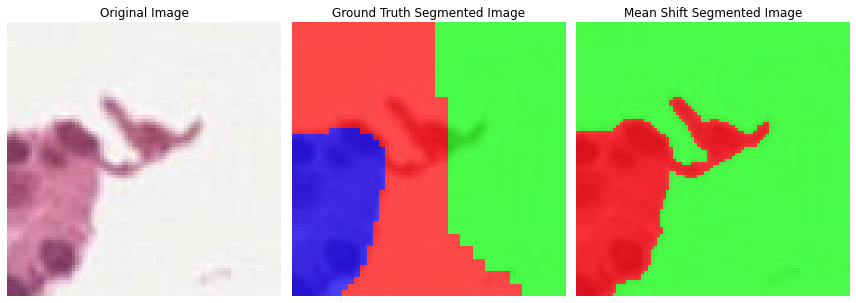

In [22]:
mask_file = mask_files[0]
image_file = image_files[0]
tile_size = 88


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 136-sized tiles scanned: 9900
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0]
The image is all background


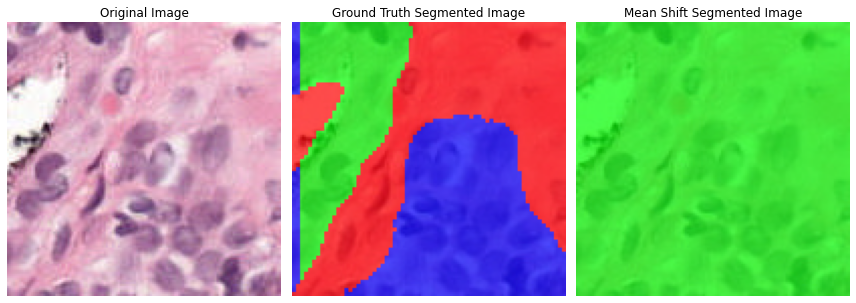

In [24]:
mask_file = mask_files[1]
image_file = image_files[1]
tile_size = 136


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 136-sized tiles scanned: 3850
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0 1]


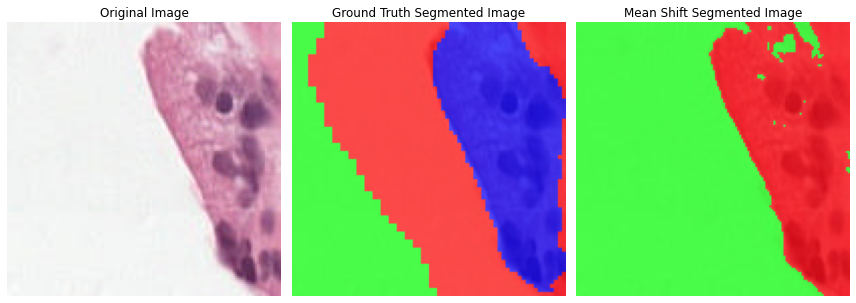

In [25]:
mask_file = mask_files[2]
image_file = image_files[2]
tile_size = 136


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 136-sized tiles scanned: 840
green : stroma (connective tissue, non-epithelium tissue)
red : cancerous epithelium (Gleason 3)
blue : cancerous epithelium (Gleason 4)
[0]
The image is all background


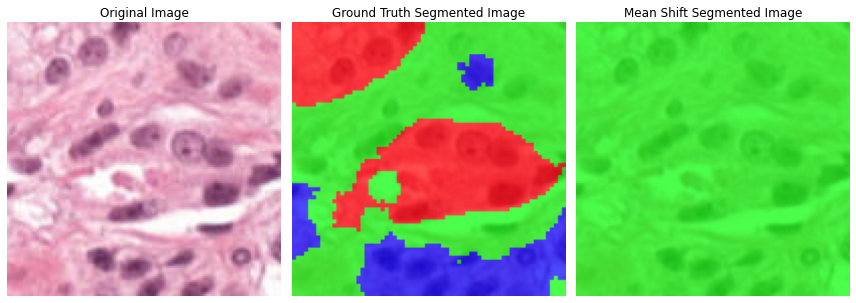

In [26]:
mask_file = mask_files[3]
image_file = image_files[3]
tile_size = 136


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 136-sized tiles scanned: 12282
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0 1]


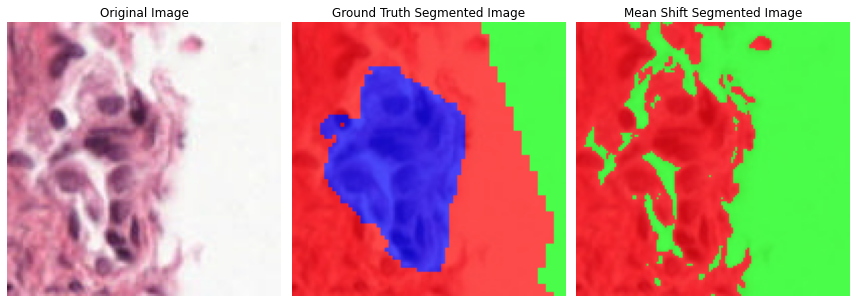

In [27]:
mask_file = mask_files[4]
image_file = image_files[4]
tile_size = 136


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 136-sized tiles scanned: 9374
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
[0 1 2]


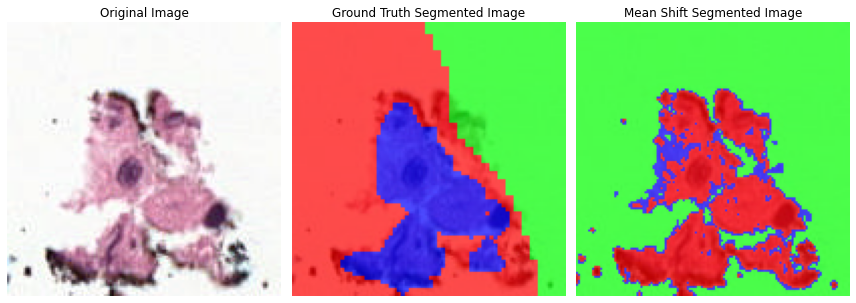

In [28]:
mask_file = mask_files[5]
image_file = image_files[5]
tile_size = 136


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 136-sized tiles scanned: 11200
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0 1 2 3]


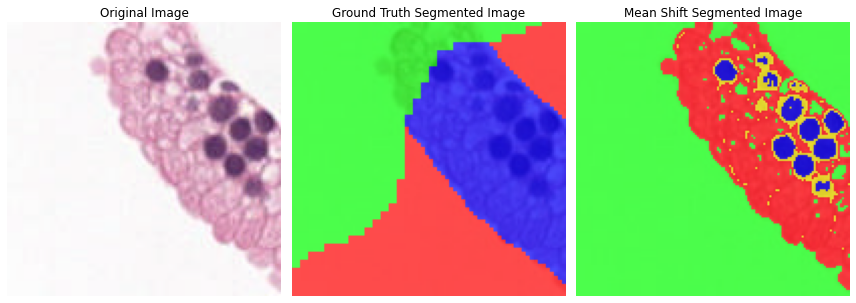

In [29]:
mask_file = mask_files[6]
image_file = image_files[6]
tile_size = 136


input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 166-sized tiles scanned: 13952
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0 1]


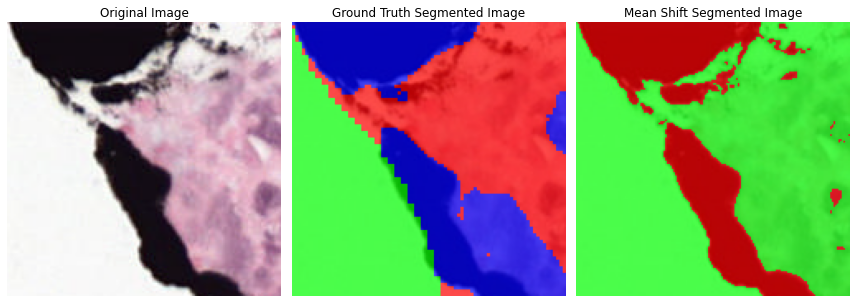

In [30]:
mask_file = mask_files[7]
image_file = image_files[7]
tile_size = 166

input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 188-sized tiles scanned: 2623
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
[0 1 2 3 4 5 6 7 8 9]


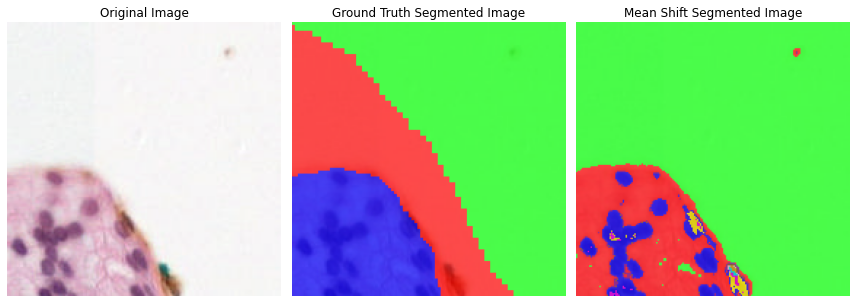

In [31]:
mask_file = mask_files[8]
image_file = image_files[8]
tile_size = 188

input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

Number of 188-sized tiles scanned: 10890
green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
[0]
The image is all background


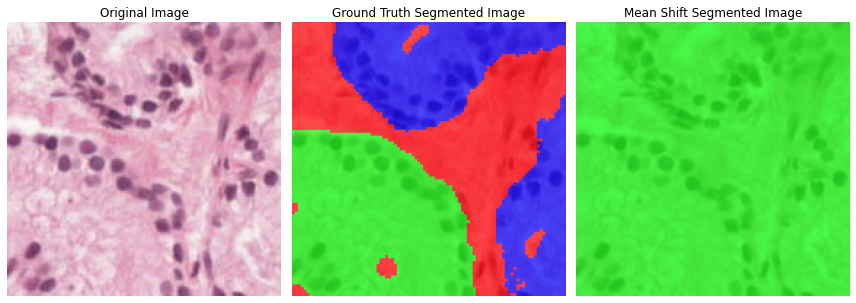

In [39]:
mask_file = mask_files[9]
image_file = image_files[9]
tile_size = 188

input_mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
input_image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))

plot_ground_truth_meanshift_segmentation_results(input_image = input_image,
                                                 input_mask = input_mask,
                                                 tile_size = tile_size)

From the above examples, we notice how the inability to set the number of clusters hurts the quality of the clustering. Furthermore, we also observe that various segmentation results are similar to the ones obtained from the K-means algorithm. Additionally, both the mean shift and DBSCAN algorithms are much slower compared to K-means. 